# Introduction 

[Official documentation](https://doc.crowdsec.net/docs/intro) of the CrowdSec software. This will remind you of the context of how the data are collected, as well as the purpose of the software. 


Objectives :
* EDA
* Constructing a graph structure from the dataset
* Training a node classifier
* Classification (is_malicious IP_validated)



---



Author **Hafdi Ramy**

# Setting up

In [253]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.semi_supervised import LabelPropagation

from scipy import stats

import xgboost

import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import session_info

import networkx as nx 

from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx


In [263]:
session_info.show()

# **I- EDA**

In [10]:
mal_ips = pd.read_csv("data/malicious_ips.csv")
auto_sys = pd.read_csv("data/autonomous_systems.csv")
watchers = pd.read_csv("data/watchers.csv")

In [11]:
mal_ips.head(3)

,id,unique_watcher_reported,attack_type,is_validated,as_num
0,3,{21},Exploit,NaN,16509.0
1,4,{25},Exploit,NaN,16509.0
2,9,"{20354, 3587, 83714, 34181, 33423, 52497, 786,...",Bruteforce,True,206728.0


In [12]:
auto_sys.head(3)

,as_num,n_ips_reported,as_name
0,3320,55294,Deutsche Telekom AG
1,4134,39891,Chinanet
2,16509,30914,AMAZON-02


In [13]:
watchers.head(3)


,id,age_in_days,activity_in_days,hp_overlap_rate,n_ips_reported
0,42266,116,116,0.04,3636
1,11213,211,157,0.31,1555
2,87345,30,28,0.09,70


**Let's try to join `mal_ips` data frame with `auto_sys` with an outer join on `as_num`, since it can give us more informations about the AS of the malicious IPs.**

In [14]:
#comparing between the data frames
auto_sys.shape,mal_ips.shape

((15161, 3), (29187, 5))

First, trying to inspect the missing values in `auto_sys` data frame.

In [15]:
auto_sys.isna().sum()

as_num            0
n_ips_reported    0
as_name           1
dtype: int64

In [16]:
#Check for the common AS between data frames.
len(mal_ips[mal_ips['as_num'].isin(auto_sys['as_num'].value_counts()[auto_sys['as_num'].value_counts()==1].index)])

29173

***We can notice that a few rows (14) will be droped after the join due their unknown AS***

______________________

## **Data preprocessing**
### Data join

In [145]:
df = mal_ips.join(auto_sys.set_index('as_num'),on='as_num')
df.head(3)

,id,unique_watcher_reported,attack_type,is_validated,as_num,n_ips_reported,as_name
0,3,{21},Exploit,NaN,16509.0,30914.0,AMAZON-02
1,4,{25},Exploit,NaN,16509.0,30914.0,AMAZON-02
2,9,"{20354, 3587, 83714, 34181, 33423, 52497, 786,...",Bruteforce,True,206728.0,14.0,Media Land LLC


In [146]:
df.isna().sum()

id                             0
unique_watcher_reported        0
attack_type                    0
is_validated               25991
as_num                         1
n_ips_reported                14
as_name                       14
dtype: int64

In [147]:
#Drop nan
df = df.dropna(subset=["as_name"])
df.shape

(29173, 7)

In [148]:
#Check that the IDs are unique
mal_ips.id.is_unique

True

## **Feature engineering**

In [149]:
#Label encoder for the attack type
le = LabelEncoder()
df['attack_type']=le.fit_transform(df['attack_type'])

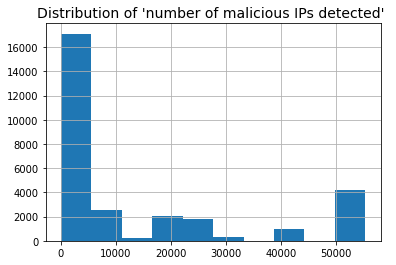

In [150]:
#fontsize
fs=14

#Check the distribution of 'n° of IPs reported'
df.n_ips_reported.hist()
plt.title("Distribution of 'number of malicious IPs detected' ",fontsize = fs)
plt.show()

* We can notice that the data is **highly positively skewed (right-skwed)**, which prevent us to make common transformations include square root, cube root, and log .. *(Usually good for this kind of situations)*
* **A large dynamic range**, so the standard linear scalers (min-max, Z-score normalization ..) scale could also be a bad transformation.
* **High percentage of outliers**, even clipping and winsorizing scalers can lead us to throw away outliers, and so much informations and miss one of data quality components : Data completeness. 

**Solution :**
* **Binning to 3 ordered categories**, as long as we can see 3 seperate intervals.
* Associate the binned data with **Box-Cox transformation** *(non linear transformation).* To control heteroscedasticity so that the variance no longer depands on the magnitude, so we can equalize the variance across all ranges of the number of ips detected per as (especially that we've opted to binning data).


In [151]:
fitted_data,_ = stats.boxcox(df['n_ips_reported']) # note that `_` is the estimated parameter lambda used for Transformation
df['n_ips_reported_bc'] = fitted_data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


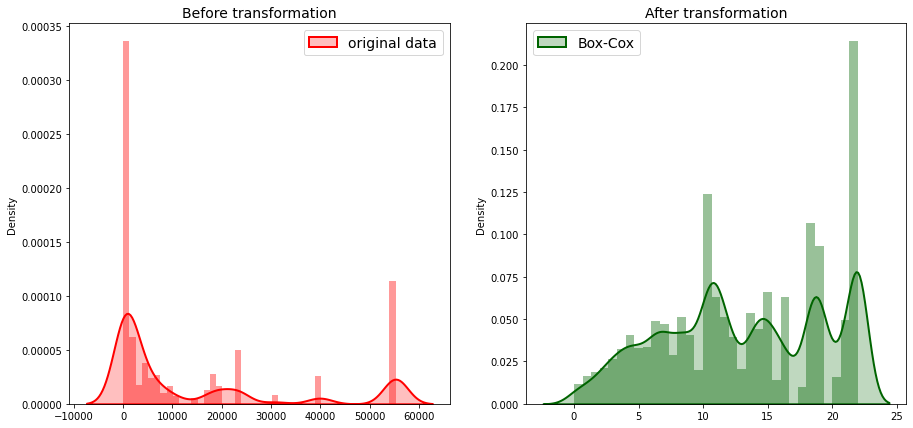

In [152]:
fig, ax = plt.subplots(1, 2)

sns.distplot(df.n_ips_reported, hist = True, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, color ="red", ax = ax[0])
 
sns.distplot(df.n_ips_reported_bc, hist = True, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, color ="darkgreen", ax = ax[1])

ax[0].set_title("Before transformation" ,fontsize=fs)
ax[1].set_title("After transformation" ,fontsize=fs)

ax[0].set(xlabel=None)
ax[1].set(xlabel=None)

ax[0].legend(labels=["original data"],fontsize = fs)
ax[1].legend(labels=["Box-Cox"],fontsize = fs)

fig.set_figheight(7)
fig.set_figwidth(15)

plt.show()

In [153]:
ips_reported =df['n_ips_reported_bc']

min=int(np.min(ips_reported))
max=int(np.max(ips_reported))
bins=np.linspace(min,max,4)

df['binned_ip_reported']=pd.cut(ips_reported,bins,right=False,precision=5,labels=[0,1,2])
df.binned_ip_reported.dtype 

CategoricalDtype(categories=[0, 1, 2], ordered=True)

In [154]:
#Transform the type to `int` for a later machine learning algorithms who don't support `cat` type
df['binned_ip_reported'] = pd.factorize(df['binned_ip_reported'])[0]
df.binned_ip_reported.dtype 

dtype('int64')

* Add a column that holds the number of watchers that reported each IP

In [155]:
#Simple replacements on `unique_watcher_reported` column
df["unique_watcher_reported"] = df["unique_watcher_reported"].apply(lambda x :pd.eval(x.replace("{","[").replace("}","]")))

#Count watchers
df["n_watchers"] = df["unique_watcher_reported"].apply(len)

## 1/ **Distribution of the attack type** in terms of the number of IPs reported 📈

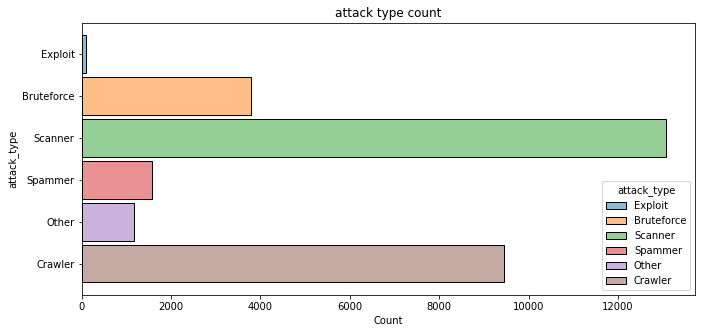

In [156]:
plt.figure(figsize=(11,5))

ax=sns.histplot(data=mal_ips, y="attack_type",binwidth=5,hue='attack_type',shrink=.9, legend=True)
plt.title("attack type count")
plt.show()

Scanner attack is the most common one.

## 2/ The names of the **top 10** 🔝 **AS hosting the highest number of malicious IPs**

In [157]:
#We seperate Labeled data and Unlabeled one to get more insights about our data.
df_valid=df.dropna(subset=['is_validated'])

### In general *(for the entire dataset, containing the validated and non-validated malicious IPs)* :

In [158]:
top10 = df.as_num.value_counts().nlargest(10).index
print("Top 10 as with the highest number of malicious ips :\n")
for id in top10 :
    print(auto_sys[auto_sys["as_num"]==id].as_name.item())

Top 10 as with the highest number of malicious ips :

Deutsche Telekom AG
Vodafone GmbH
Kyivstar PJSC
Chinanet
CLOUDFLARENET
Hetzner Online GmbH
Alpha Strike Labs GmbH
DIGITALOCEAN-ASN
Telefonica Germany
MICROSOFT-CORP-MSN-AS-BLOCK


### For the validated malicious IPs✅ only :




In [159]:
top10_v = df_valid.as_num.value_counts().nlargest(10).index
print("Top 10 as with the highest number of validated malicious ips :\n")
for id in top10_v :
    print(auto_sys[auto_sys["as_num"]==id].as_name.item())

Top 10 as with the highest number of validated malicious ips :

CLOUDFLARENET
MICROSOFT-CORP-MSN-AS-BLOCK
PONYNET
Cia Triad Security LLC
DIGITALOCEAN-ASN
Alpha Strike Labs GmbH
QUINTEX
Chinanet
OVH SAS
Hetzner Online GmbH




----



## 3/ The names of the **top 10** 🔝 **AS hosting malicious IPs which perform the highest number of attack** 🏆

### In general *(for the entire dataset, containing the validated and non-validated malicious IPs)* :

In [160]:
top10 = df.loc[df.n_watchers.nlargest(10).index].as_num
print("Top 10 as hosting IPs which perform the highest number of attack :\n")
for i in top10 :
    print(auto_sys[auto_sys["as_num"]==i].as_name.item())

Top 10 as hosting IPs which perform the highest number of attack :

CLOUDFLARENET
CLOUDFLARENET
China Mobile communications corporation
Chinanet
Chinanet
China Mobile communications corporation
China Mobile communications corporation
China Mobile communications corporation
Chinanet
Chinanet


### For just the validated malicious IPs ✅ :




In [161]:
top10_v = df_valid.loc[df_valid.n_watchers.nlargest(10).index].as_num
print("Top 10 as hosting validated IPs which perform the highest number of attack :\n")
for i in top10_v :
    print(auto_sys[auto_sys["as_num"]==i].as_name.item())

Top 10 as hosting validated IPs which perform the highest number of attack :

China Mobile communications corporation
Chinanet
Chinanet
China Mobile communications corporation
China Mobile communications corporation
China Mobile communications corporation
Chinanet
Chinanet
China Mobile communications corporation
China Mobile communications corporation


_______




## 4/ **Distribution of the average** `activity_in_days` and `age_in_days` of the **watchers who reported each malicious IPs** *(for the validated IPs only)*

In [162]:
df["avg_activity_in_days"] = df.unique_watcher_reported.apply(lambda x: watchers.set_index("id").loc[x].activity_in_days.mean())
df["avg_age_in_days"] = df.unique_watcher_reported.apply(lambda x: watchers.set_index("id").loc[x].age_in_days.mean())


**Boxenplot** is the prefered plots to visulize data distrbution, because he is more fast *(less computing power is needed compared to Vilionplot for example)..*

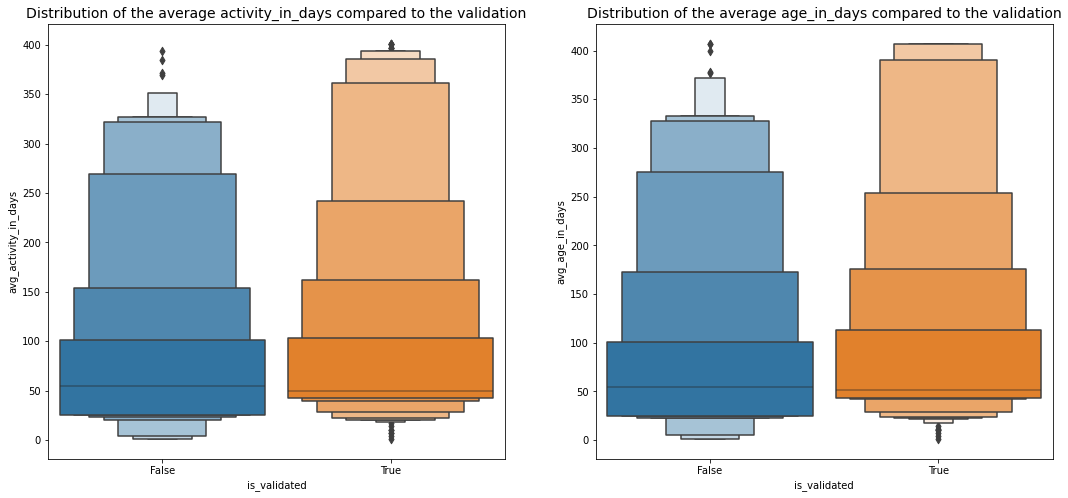

In [163]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(18,8))

sns.boxenplot(data = df, x="is_validated", y="avg_activity_in_days", scale="linear",width=0.9, ax=ax[0])
ax[0].set_title("Distribution of the average activity_in_days compared to the validation" ,fontsize=fs)

sns.boxenplot(data = df, x="is_validated", y="avg_age_in_days", scale="linear",width=0.9, ax=ax[1])
ax[1].set_title("Distribution of the average age_in_days compared to the validation" ,fontsize=fs)

fig.show()

Validated malicious IPs have bigger `avg_age_in_day` and  `avg_activity_in_day`.

In [ ]:
#For the labeled data
df_valid["avg_activity_in_days"] = df_valid.unique_watcher_reported.apply(lambda x: watchers.set_index("id").loc[x].activity_in_days.mean())
df_valid["avg_age_in_days"] = df_valid.unique_watcher_reported.apply(lambda x: watchers.set_index("id").loc[x].age_in_days.mean())

## 5/ **The 10 watchers which suffered from the highest number of attacks**

In [223]:
top10_watchers = watchers.sort_values(by='n_ips_reported',ascending=False)['id'][:10].values

print("The 10 watchers which suffered from the highest number of attacks :\n")
for id in top10_watchers :
    print(watchers[watchers["id"]==id].id.item())

The 10 watchers which suffered from the highest number of attacks :

47
92263
9662
9663
9563
7286
77642
24249
715
561


## **Add more features** 
* Since `activity_in_days` always less or equal `age_in_days`, a proportion can be a good additional feature. *(values will be already scalled)*
* Scaling columns that we added (`avg_age_in_days`,`avg_activity_in_days` and `n_watchers`) 

In [ ]:
df['diff_act']= df['avg_activity_in_days']/df['avg_age_in_days']
df_valid['diff_act']=df_valid['avg_activity_in_days']/df_valid['avg_age_in_days']

In [ ]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))

_ = df['avg_activity_in_days'].values.reshape(-1, 1)
df['avg_activity_in_days'] = minmaxscaler.fit_transform(_)

_ = df['avg_age_in_days'].values.reshape(-1, 1)
df['avg_age_in_days'] = minmaxscaler.fit_transform(_)

_ = df['n_watchers'].values.reshape(-1, 1)
df['n_watchers'] = minmaxscaler.fit_transform(_)

#For labeled data
_ = df_valid['avg_activity_in_days'].values.reshape(-1, 1)
df_valid['avg_activity_in_days'] = minmaxscaler.fit_transform(_)

_ = df_valid['avg_age_in_days'].values.reshape(-1, 1)
df_valid['avg_age_in_days'] = minmaxscaler.fit_transform(_)

_ = df_valid['n_watchers'].values.reshape(-1, 1)
df_valid['n_watchers'] = minmaxscaler.fit_transform(_)

____________


# **II-Graph**




Graph $G = (V,E)$ where a node $v$ is a malicious IP and an edge $e$ links two malicious IPs if they were reported by the same watcher. Hence the edges are weighted by the number of times 2 malicious IPs were reported by the same watchers.

In [171]:
#We will take only the relevant features
features = df_valid.set_index("id")[["diff_act","n_ips_reported_bc","n_watchers","avg_activity_in_days","binned_ip_reported","avg_age_in_days"]].to_dict(orient="index")
classes = df_valid.set_index("id")[["attack_type"]].to_dict(orient="index")

In [172]:
#Dict to intialise nodes later
for key, value in features.items():
    features[key] = list(value.values())

for key, value in classes.items():
    classes[key] = list(value.values())

In [173]:
#Define the graph nodes
nodes_id = df_valid.id.to_list()
nodes = [(node,{'x':features[node],'y':classes[node]}) for node in nodes_id]

In [174]:
#Define the undirected weighted edges
watchers_list = df_valid.unique_watcher_reported.to_list()
edges = [] 
for i in range(len(nodes_id)):
    for j in range(i+1,len(nodes_id)):
        weight = len(set(watchers_list[i])&set(watchers_list[j]))  
        if weight!=0 :  
            edges.append((nodes_id[i], nodes_id[j], weight)) 

In [175]:
#Graph
graph = nx.Graph() 

graph.add_nodes_from(nodes)
graph.add_weighted_edges_from(edges)

nb_nodes = graph.number_of_nodes()
nb_edges = graph.number_of_edges()

### **Subgraph**

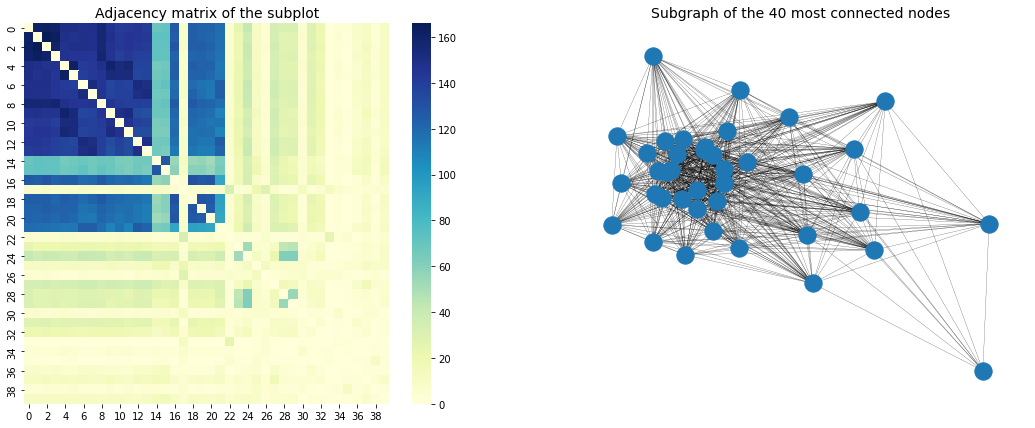

In [176]:
#Only for the 40 most connected nodes 
n =40
df_40 = df_valid.loc[df_valid.n_watchers.nlargest(n).index]

nodes_40 = df_40.id.tolist()

watchers_list_40 = df_40.unique_watcher_reported.tolist()
edges_40 = [] 
for i in range(len(nodes_40)):
    for j in range(i+1,len(nodes_40)):
        weight = len(set(watchers_list_40[i])&set(watchers_list_40[j]))
        if weight!=0 : 
            edges_40.append((nodes_40[i], nodes_40[j], weight)) 

graph_40 = nx.Graph() 

graph_40.add_nodes_from(nodes_40)
graph_40.add_weighted_edges_from(edges_40)

nb_nodes = graph_40.number_of_nodes()
nb_edges = graph_40.number_of_edges()

adj_40 = nx.adjacency_matrix(graph_40) 

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,7)) 

sns.heatmap(adj_40.todense(), cmap="YlGnBu",ax=ax[0])
ax[0].set_title("Adjacency matrix of the subplot",fontsize=fs)


nx.draw(graph_40, pos=nx.spring_layout(graph_40, seed=8), width=0.2)
ax[1].set_title("Subgraph of the 40 most connected nodes",fontsize=fs)

fig.show()

# **III- Training a node classifier (GCN)** 


In [177]:
#convert the graph to graph data 
pyg_graph = gdf = from_networkx(graph) 

#train test split 
train_ratio = 0.8
val_ratio = 0.1

n_nodes = pyg_graph.x.shape[0]
num_train = int(n_nodes * train_ratio)
num_val = int(n_nodes * val_ratio)

index = [i for i in range(n_nodes)]
np.random.shuffle(index)

train_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
train_mask[index[:num_train]] = True

test_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
test_mask[index[num_train:num_train+num_val]] = True

val_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
val_mask[index[num_train+num_val:]] = True

pyg_graph.train_mask = train_mask
pyg_graph.test_mask = test_mask
pyg_graph.val_mask = val_mask

In [209]:
class GCN(torch.nn.Module):
    def __init__(self, number_of_features, number_of_classes):
        super().__init__()
        torch.manual_seed(888)
        self.conv1 = GCNConv(number_of_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.classifier = nn.Linear(64, number_of_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()

        out = self.classifier(h)
        return out, h

In [222]:
gcn = GCN(6, 6)
optimizer = Adam(gcn.parameters(), lr=0.06)
criterion = nn.CrossEntropyLoss()
epochs = 400

writer = SummaryWriter(log_dir="output/gcn/")

loop = tqdm(range(1, epochs+1))
for epoch in loop:
      gcn.train()
      optimizer.zero_grad()  # clear gradients
      out,_ = gcn(gdf.x, gdf.edge_index)  #  feedforward
      loss = criterion(out[gdf.train_mask.flatten()], gdf.y[gdf.train_mask].flatten())  # compute the loss solely based on the training nodes
      loss.backward()  
      optimizer.step() 

      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[gdf.val_mask.flatten()] == gdf.y[gdf.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(gdf.val_mask.sum())  # Derive ratio of correct predictions.
    
      loop.set_postfix_str(f'train_loss: {loss:.4f} val_accuracy : {val_acc:.4f}')
      writer.add_scalars("losses",{"train": np.round(loss.item(),3)}, epoch)

100%|██████████| 400/400 [08:46<00:00,  1.32s/it, train_loss: 0.2635 val_accuracy : 0.9094]


In [225]:
#test set
gcn.eval()

out,_ = gcn(gdf.x, gdf.edge_index)
pred = out.argmax(dim=1)
test_correct = pred[gdf.test_mask.flatten()] == gdf.y[gdf.test_mask]
test_acc = int(test_correct.sum()) / int(gdf.test_mask.sum())  

print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.90


# **VI- Semi Supervised Learning** 🤖

In [233]:
df = df.reset_index()

In [234]:
#Extracting relevent features
df = df.set_index('id')
data = df[["diff_act","attack_type","n_ips_reported_bc","n_watchers","avg_activity_in_days","avg_age_in_days","binned_ip_reported"]]

#One Hot encoding for attack type
attack_type_encoded = pd.get_dummies(data['attack_type'])
data = data.drop('attack_type',axis=1)
data = pd.concat([data, attack_type_encoded], axis=1)

#Mapping the entire dataframe, putting -1 to the unlabeled data
labels = df['is_validated'].replace({True:1,False:0,np.nan:-1})

In [236]:
data.head(3)

,diff_act,n_ips_reported_bc,n_watchers,avg_activity_in_days,avg_age_in_days,binned_ip_reported,0,1,2,3,4,5
id,,,,,,,,,,,,
3,0.975430,20.004788,0.000,0.990000,1.000000,0,0,0,1,0,0,0
4,0.985258,20.004788,0.000,1.000000,1.000000,0,0,0,1,0,0,0
9,0.869832,3.088389,0.168,0.352209,0.399301,1,1,0,0,0,0,0


In [237]:
#Exporting data
data.to_csv('data/output/prepared_data.csv') 
labels.to_csv('data/output/labels.csv')

In [238]:
#Importing data 
X = pd.read_csv('data/output/prepared_data.csv')
X = X.to_numpy()
y = pd.read_csv('data/output/labels.csv')
y = y['is_validated']

In semi supervised learning, GNNs are one of the acvanced and most robest ways to do it. Beceause the adjancy matrix A provide us the possibility to decompose it to Laplacien matrix that help us in many algorithms, like spectral clustring (a powerfull clustring methode), and more algorithms ..

**Adjacency matrix**
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

**Degree matrix**
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

**Laplacian**
\begin{align*}
L &= D - A.
\end{align*}

**Normalized Laplacian**
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}



___

**Label propagation** : It minimizes a loss function that has regularization properties and is often more robust to noise. The algorithm iterates on a modified version of the original graph and normalizes the edge weights by computing the normalized graph Laplacian matrix. This procedure is also used in Spectral clustering.


We will use SKlearn Label Propagation classifier.

In [239]:
#Fitting with entire dataset
label_prop_model = LabelPropagation()
label_prop_model.fit(X, y)

LabelPropagation()

In [240]:
#Predicting on the whole dataset
pred_lb = label_prop_model.predict(X)
print("Accuracy of Label Spreading: ",'{:.2%}'.format(label_prop_model.score(X,pred_lb)))

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Accuracy of Label Spreading:  100.00%


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [248]:
#Using this newly predicted labels and try to build a XGBoost Model (Tree based model), without hyper parameters tunning (simple model)
xgb= xgboost.XGBClassifier()


X_train, X_test, y_train, y_test = train_test_split(X, pred_lb, test_size=0.1, random_state=888) 

In [249]:
#Fitting
xgb.fit(X_train,y_train)

XGBClassifier()

In [250]:
#Scores on 4 folds cross validation
scores = cross_val_score(xgb, X_train, y_train, scoring="accuracy", cv=4)
scores

array([0.9194089 , 0.91407678, 0.91986594, 0.91208289])

In [251]:
#Claasification report
y_pred = xgb.predict(X_test)
cm = classification_report(y_test,y_pred) 
print(cm)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2525
           1       0.86      0.44      0.58       393

    accuracy                           0.91      2918
   macro avg       0.89      0.71      0.77      2918
weighted avg       0.91      0.91      0.90      2918





---



# **V- Appendix** 

### **Conclusion**
* Manually induce unlabeled samples in dataset
* Use Semi-Supervised Learning Estimator (Label propagation) to predict labels for the unlabeled samples.
* Build Classifier Model using the predicted labels.

### **Future steps**
* Try to build the graph with **jraph**, a lightweight library for working with **GNNs** in **JAX**.




---



### **References** 
* [**Scikit-learn**, Semi-Supervised.](https://scikit-learn.org/stable/modules/semi_supervised.html#label-propagation)
* [**Thomas Kipf**, GRAPH CONVOLUTIONAL NETWORKS.](http://tkipf.github.io/graph-convolutional-networks/)
* [**Gowri Shankar**, Graph Convolution Network - A Practical Implementation of Vertex Classifier and it's Mathematical Basis](https://gowrishankar.info/blog/graph-convolution-network-a-practical-implementation-of-vertex-classifier-and-its-mathematical-basis/#graph-nn-classifier)
* [**Xing Li, Wei Wei, Xiangnan Feng, Xue Liu, Zhiming Zheng**,Representation Learning of Graphs
Using Graph Convolutional Multilayer
Networks Based on Motifs](https://arxiv.org/abs/1609.02907)

### **Apperciation**
My sincers apperciations to **Bigmama Technology** for this challange.